## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import os
import matplotlib.image as mpimg
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML
%matplotlib inline

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('../camera_cal/calibration*.jpg')

# Step through the list and search for chessboard corners
for fname in images:
    print(fname)
    img = mpimg.imread(fname)
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)

    # If found, add object points, image points
    if ret == True:
        print('found')
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        cv2.imshow('img',img)
        cv2.waitKey(1)

cv2.destroyAllWindows()

../camera_cal\calibration1.jpg
../camera_cal\calibration10.jpg
found
../camera_cal\calibration11.jpg
found
../camera_cal\calibration12.jpg
found
../camera_cal\calibration13.jpg
found
../camera_cal\calibration14.jpg
found
../camera_cal\calibration15.jpg
found
../camera_cal\calibration16.jpg
found
../camera_cal\calibration17.jpg
found
../camera_cal\calibration18.jpg
found
../camera_cal\calibration19.jpg
found
../camera_cal\calibration2.jpg
found
../camera_cal\calibration20.jpg
found
../camera_cal\calibration3.jpg
found
../camera_cal\calibration4.jpg
../camera_cal\calibration5.jpg
../camera_cal\calibration6.jpg
found
../camera_cal\calibration7.jpg
found
../camera_cal\calibration8.jpg
found
../camera_cal\calibration9.jpg
found


## Undistorted Images

In [2]:
img=cv2.imread(images[1])
img_size = (img.shape[1], img.shape[0])
print(img_size)

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, img_size,None,None)


#undistort the images
for fname in images:
    img = cv2.imread(fname)
    img_undist = cv2.undistort(img, mtx, dist, None, mtx)
    cv2.imshow('img',img_undist)
    cv2.waitKey(1)
cv2.destroyAllWindows()

(1280, 720)


## Read Test Images

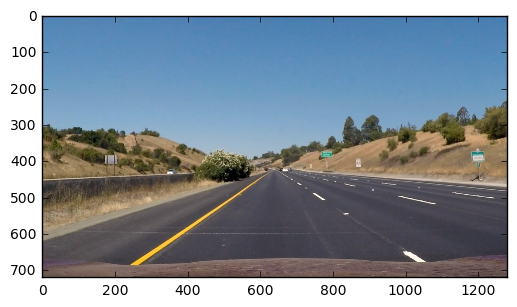

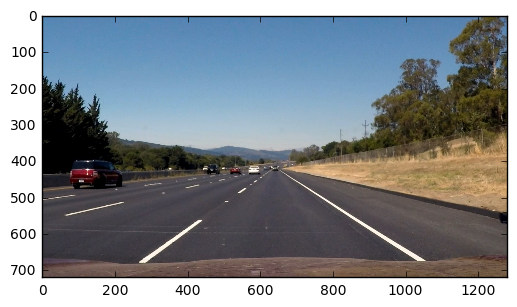

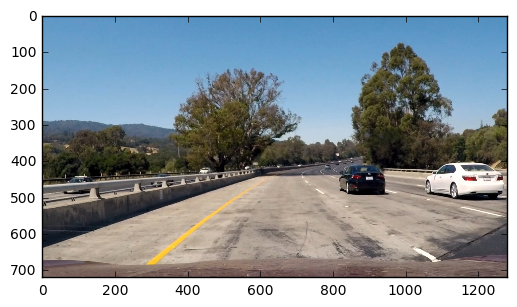

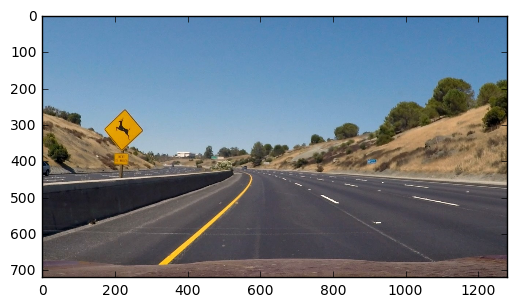

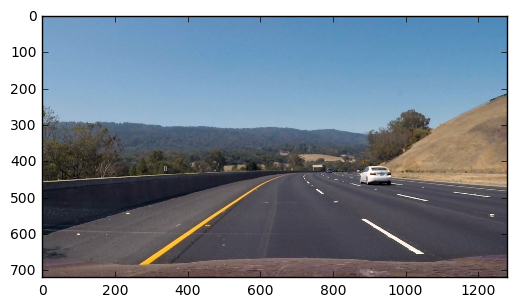

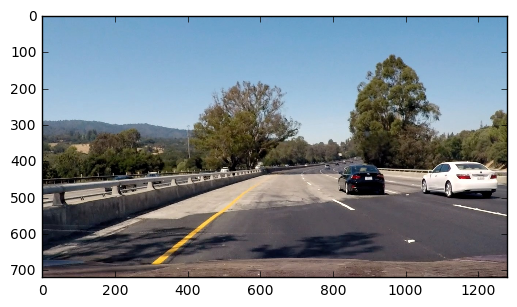

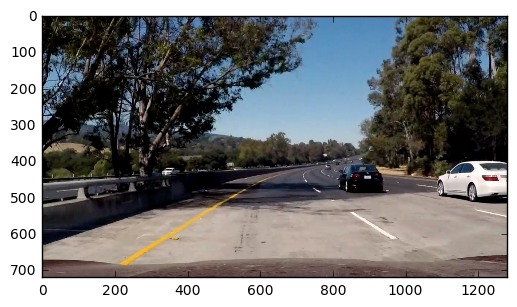

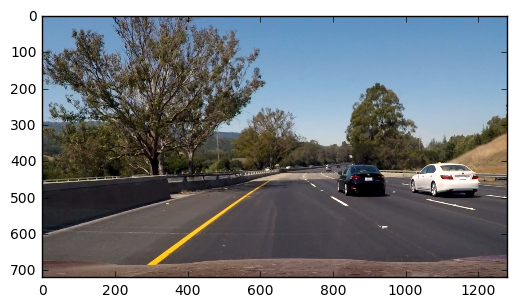

In [3]:
image_names=os.listdir("test_images/")
i=0
test_images=[]
for file in image_names:
    image=mpimg.imread("test_images//"+file)
    plt.figure(i)
    i=i+1;
    plt.imshow(image)
    test_images.append(image)
i=0

## Thresholding - Combination of absolute sobel, magnitude color and gradient thresholds

In [4]:

#Sobel on or y 
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    # Apply threshold
    #img = cv2.undistort(image, mtx, dist, None, mtx)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1))

    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1

    return binary_output


#Sobel on both magnitude of x & y gradients
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    # Apply threshold
    
    #grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    #Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1)

    #Calculate the magnitude 
    abs_sobel =np.sqrt(sobelx**2 + sobely**2)
    
    #Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    
    mag_binary = np.zeros_like(scaled_sobel)
    mag_binary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1

    return mag_binary


#Directional Thresholding
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    # Apply threshold
    
    #Gray Image
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    
    # Gradient Direction
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

    return dir_binary


#Color thresholding based on "S" channel
def color_threshold(img, thresh=(0, 255)):
    
    #Convert to hls
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]

    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= thresh[0]) & (s_channel <= thresh[1])] = 1

    return s_binary



## Function that applies all thresholding and combines them

In [5]:
def find_lane(image_undist):
    #image_undist = cv2.undistort(image, mtx, dist, None, mtx)
    gradx = abs_sobel_thresh(image_undist, orient='x', sobel_kernel=3, thresh=(20, 120))
    grady = abs_sobel_thresh(image_undist, orient='y', sobel_kernel=5, thresh=(20, 120))
    mag_binary = mag_thresh(image_undist, sobel_kernel=3, mag_thresh=(20, 100))
    dir_binary = dir_threshold(image_undist, sobel_kernel=3, thresh=(0.7, 1.3))
    color_binary = color_threshold(image_undist, thresh=(150, 255))
    
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1)) | (color_binary==1)] = 1
    #combined[((mag_binary == 1) & (dir_binary == 1))] = 1
    return combined

## Main Lane finding Pipeline

In [20]:
src = np.float32(
    [[760,450],
     [1270,680],
     [10,680],
     [520,450]])
    
dst = np.float32(
    [[1280,0],
     [1050,690],
     [230,690],
     [0,0]])
    
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

rho = 1
theta = np.pi/180
threshold = 10
min_line_length =25
max_line_gap = 4
low_threshold = 70
high_threshold = 256
ignore_mask_color = 256

def get_lane_points(left_lane_image,right_lane_image,imshape):

    left_lane_image_array=np.asarray(left_lane_image)
    p_left=np.where(left_lane_image_array!=0)
    points_left=np.column_stack((p_left[1],p_left[0]))

    right_lane_image_array=np.asarray(right_lane_image)
    p_right=np.where(right_lane_image_array!=0)
    points_right=np.column_stack((p_right[1],p_right[0]))
    return points_left,points_right



def fit_equation(points_left,points_right):
    left_yvals=points_left[:,1]
    left_xvals=points_left[:,0]

    right_yvals=points_right[:,1]
    right_xvals=points_right[:,0]

    # Fit a second order polynomial to each fake lane line
    left_fit = np.polyfit(left_yvals, left_xvals, 2)
    left_fitx = left_fit[0]*left_yvals**2 + left_fit[1]*left_yvals + left_fit[2]
    right_fit = np.polyfit(right_yvals, right_xvals, 2)
    right_fitx = right_fit[0]*right_yvals**2 + right_fit[1]*right_yvals + right_fit[2]

    #plt.plot(left_xvals, yvals, 'o', color='red')
    #plt.plot(rightx, yvals, 'o', color='blue')
    #plt.xlim(0, 1280)
    #plt.ylim(0, 720)
    #plt.plot(left_fitx, left_yvals, color='green', linewidth=3)
    #plt.plot(right_fitx, right_yvals, color='green', linewidth=3)
    #plt.gca().invert_yaxis() # to visualize as we do the images


    y_eval_left = np.max(left_yvals)
    y_eval_right = np.max(right_yvals)

    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meteres per pixel in x dimension

    left_fit_cr = np.polyfit(left_yvals*ym_per_pix, left_xvals*xm_per_pix, 2)
    right_fit_cr = np.polyfit(right_yvals*ym_per_pix, right_xvals*xm_per_pix, 2)

    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval_left + left_fit_cr[1])**2)**1.5) \
                                 /np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval_right + right_fit_cr[1])**2)**1.5) \
                                    /np.absolute(2*right_fit_cr[0])
    #print(left_curverad, right_curverad)
    return left_fitx,left_yvals,right_fitx,right_yvals,left_curverad,right_curverad


def lane_pipeline(image):
    image_undist = cv2.undistort(image, mtx, dist, None, mtx)
    imshape = image.shape
    lane_found=find_lane(image_undist)
    b_img=cv2.warpPerspective(lane_found, M, img_size, flags=cv2.INTER_LINEAR)
    
    histogram = np.sum(b_img[b_img.shape[0]/2:,:], axis=0)

    left_lane_hist=histogram[250:600]
    right_lane_hist=histogram[850:1100]

    a=np.where(left_lane_hist==left_lane_hist.max())
    left_lane_position=a[0]+250;
    left_lane_begin=left_lane_position[0]
    save_left_begin=left_lane_begin

    b=np.where(right_lane_hist==right_lane_hist.max())
    right_lane_position=b[0]+850;
    right_lane_begin=right_lane_position[0]
    save_right_begin=right_lane_begin

    image_height=imshape[0]

    left_pos=left_lane_begin
    right_pos=right_lane_begin

    left_lane_image = np.zeros_like(b_img)
    right_lane_image = np.zeros_like(b_img)
    
    
    
    for num in range(0,8):
        height_max=image_height - int(image_height*num/8)
        height_low=image_height - int(image_height*(num+1)/8)

        histogram = np.sum(b_img[height_low:height_max,:], axis=0)

        #left lane histogram and left_pos adjustment
        left_lane_hist=histogram[left_pos-50:left_pos+50]

        if(left_lane_hist.max() > 0):
            a=np.where(left_lane_hist==left_lane_hist.max())
            left_lane_position=a[0]+left_pos-50;
            left_pos=left_lane_position[0]

        
        #right lane histogram and right_pos adjustment
        right_lane_hist=histogram[right_pos-50:right_pos+50]
        
        if(right_lane_hist.max() > 0):
            a=np.where(right_lane_hist==right_lane_hist.max())
            right_lane_position=a[0]+right_pos-50;
            right_pos=right_lane_position[0]

        #left lane
        mask_l = np.zeros_like(b_img)
        vertices_l = np.array([[(left_pos-50,height_max),(left_pos-50, height_low), (left_pos+50, height_low), (left_pos+50,height_max)]], dtype=np.int32)
        cv2.fillPoly(mask_l, vertices_l, ignore_mask_color)
        masked_edges_l = cv2.bitwise_and(b_img, mask_l)
        left_lane_image=cv2.bitwise_or(masked_edges_l, left_lane_image)

        #right lane
        mask_r = np.zeros_like(b_img)
        vertices_r = np.array([[(right_pos-50,height_max),(right_pos-50, height_low), (right_pos+50, height_low), (right_pos+50,height_max)]], dtype=np.int32)
        cv2.fillPoly(mask_r, vertices_r, ignore_mask_color)
        masked_edges_r = cv2.bitwise_and(b_img, mask_r)
        right_lane_image=cv2.bitwise_or(masked_edges_r, right_lane_image)    
        
    #get lane points
    points_left,points_right=get_lane_points(left_lane_image,right_lane_image,imshape)
        
    #fit equation
    left_fitx,left_yvals,right_fitx,right_yvals,left_curverad,right_curverad=fit_equation(points_left,points_right)
        
    color_warp =np.zeros_like(image)

    pts_left = np.array([np.transpose(np.vstack([left_fitx, left_yvals]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, right_yvals])))])
    pts = np.hstack((pts_left, pts_right))

    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    newwarp = cv2.warpPerspective(color_warp, Minv, (image.shape[1], image.shape[0])) 

    # Combine the result with the original image
    result = cv2.addWeighted(image_undist, 1, newwarp, 0.3, 0)
    
    text_left='left curvature - '+ str(left_curverad)
    text_right='right curvature - ' + str(right_curverad)
    curve=(left_curverad+right_curverad)/2
    text_vehicle_curvature='Radius Curvature - ' + str(curve)
    text_vehicle_position='Vehicle Position - ' + str(1)
    pos=save_left_begin+((save_right_begin-save_left_begin)/2)
    vehicle_pos=((imshape[1]/2) - pos)*3.7/700
    
    if(vehicle_pos >= 0):
        text_vehicle_position='Vehicle left from center by - ' + str(vehicle_pos)
    if(vehicle_pos < 0):
        text_vehicle_position='Vehicle right from center by - ' + str(0-vehicle_pos)
    
    #cv2.putText(result,text_left,(100,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4)
    #cv2.putText(result,text_right,(100,200), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4)
    cv2.putText(result,text_vehicle_curvature,(50,100), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4)
    cv2.putText(result,text_vehicle_position,(50,200), cv2.FONT_HERSHEY_SIMPLEX, 2,(255,255,255),4)
    
    return result

## Test Pipeline on images

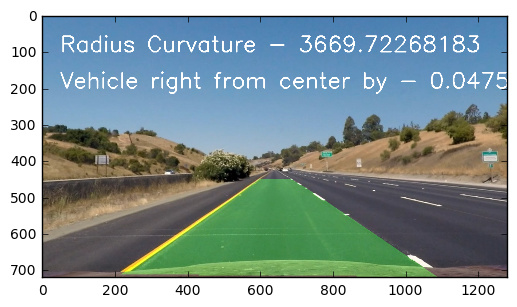

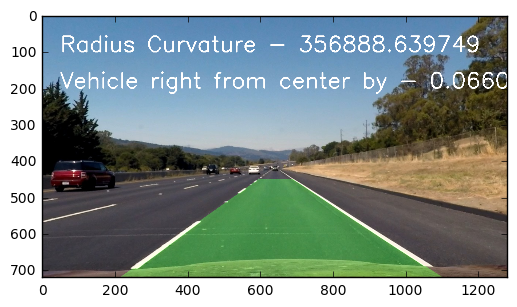

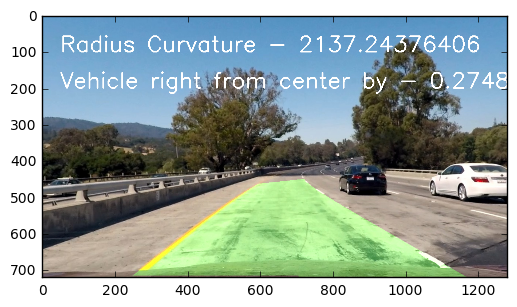

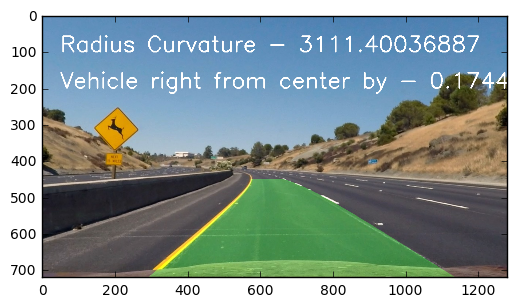

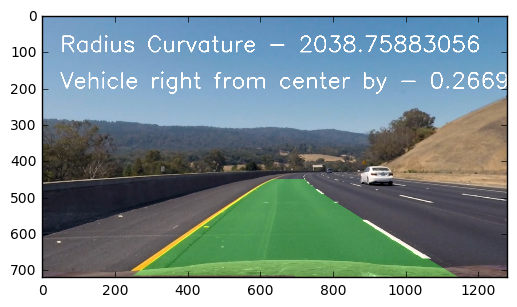

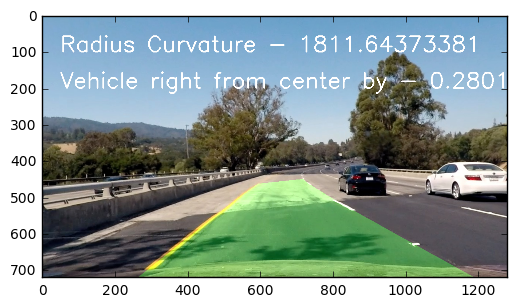

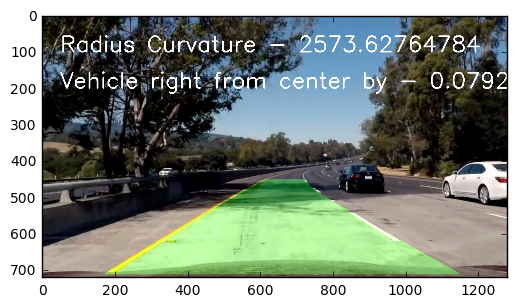

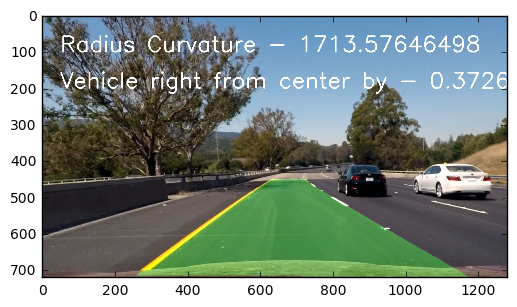

In [25]:
i=0
for file in image_names:
    plt.figure(i)
    i=i+1
    image=mpimg.imread("test_images//"+file)
    lane_got=lane_pipeline(image)
    cv2.imwrite(file,lane_got)
    plt.imshow(lane_got)
    

## Test on Video

In [22]:
lane_output = 'Lane_project_video.mp4'
clip1 = VideoFileClip("project_video.mp4")
lane_clip = clip1.fl_image(lane_pipeline) #NOTE: this function expects color images!!
%time lane_clip.write_videofile(lane_output, audio=False)

[MoviePy] >>>> Building video Lane_project_video.mp4
[MoviePy] Writing video Lane_project_video.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [13:38<00:00,  2.34it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: Lane_project_video.mp4 

Wall time: 13min 38s


## Result

In [23]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(lane_output))